In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Работа с данными

In [ ]:
#train
train = pd.read_csv('/content/drive/MyDrive/B_l_train.csv')
#test
test = pd.read_csv('/content/drive/MyDrive/B_l_test.csv')

In [ ]:
data = train.append(test)
data.shape

(947, 4)

In [ ]:
data

,title,content,label,link
0,An Independent Voter Guide to The Impeachment ...,The impeachment trial ofÂ President Donald J. ...,1,ivn.us
1,An App Called Libby and the Surprisingly Big B...,"Steve Potash , the bearded and bespectacled pr...",0,newyorker.com
2,Introducing the 2017 Cook Political Report Par...,Introducing the 2017 Cook Political Report Par...,1,cookpolitical.com
3,"Bad education A mathematician, astrophysicist,...",Natalia Kolesnikova / AFP / Scanpix / LETA\n\n...,0,meduza.io
4,A Germantown elementary school has gone virtua...,A Germantown elementary school has gone virtua...,1,sctimes.com
...,...,...,...,...
100,WALLACE OUT AT FOXFOXNEWS requiring shots...Th...,Chris Wallace is leaving Fox News .\nHe is set...,0,mediaite.com
101,Trump’s Justices Protect Worship Services From...,Trump’s Justices Protect Worship Services From...,2,nationalcenter.org
102,6 Ways to Make Sure Your Next Conference Runs ...,Are you the sole organizer of your next super ...,0,the-daily.buzz
103,DRUDGE WEATHER REPORTÂ®DRUDGE EXCLUSIVE: BUSH ...,STREISAND CELEBRATES HILLARY VICTORY'HAPPY DAY...,2,drudgereport.com


Удаление NaN

In [ ]:
train = train.dropna()
test = test.dropna()
data = data.dropna()

In [ ]:
data

,title,content,label,link
0,An Independent Voter Guide to The Impeachment ...,The impeachment trial ofÂ President Donald J. ...,1,ivn.us
1,An App Called Libby and the Surprisingly Big B...,"Steve Potash , the bearded and bespectacled pr...",0,newyorker.com
2,Introducing the 2017 Cook Political Report Par...,Introducing the 2017 Cook Political Report Par...,1,cookpolitical.com
3,"Bad education A mathematician, astrophysicist,...",Natalia Kolesnikova / AFP / Scanpix / LETA\n\n...,0,meduza.io
4,A Germantown elementary school has gone virtua...,A Germantown elementary school has gone virtua...,1,sctimes.com
...,...,...,...,...
100,WALLACE OUT AT FOXFOXNEWS requiring shots...Th...,Chris Wallace is leaving Fox News .\nHe is set...,0,mediaite.com
101,Trump’s Justices Protect Worship Services From...,Trump’s Justices Protect Worship Services From...,2,nationalcenter.org
102,6 Ways to Make Sure Your Next Conference Runs ...,Are you the sole organizer of your next super ...,0,the-daily.buzz
103,DRUDGE WEATHER REPORTÂ®DRUDGE EXCLUSIVE: BUSH ...,STREISAND CELEBRATES HILLARY VICTORY'HAPPY DAY...,2,drudgereport.com


Взглянем на распределение по классам на всех данных

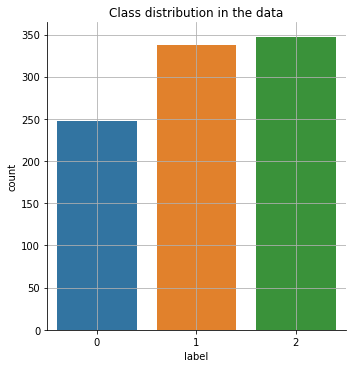

In [ ]:
g = sns.catplot(x='label',
                kind="count",
                data=data)
plt.grid()
plt.title("Class distribution in the data");

Разобьем train на train и val

In [ ]:
train

,title,content,label,link
0,An Independent Voter Guide to The Impeachment ...,The impeachment trial ofÂ President Donald J. ...,1,ivn.us
1,An App Called Libby and the Surprisingly Big B...,"Steve Potash , the bearded and bespectacled pr...",0,newyorker.com
2,Introducing the 2017 Cook Political Report Par...,Introducing the 2017 Cook Political Report Par...,1,cookpolitical.com
3,"Bad education A mathematician, astrophysicist,...",Natalia Kolesnikova / AFP / Scanpix / LETA\n\n...,0,meduza.io
4,A Germantown elementary school has gone virtua...,A Germantown elementary school has gone virtua...,1,sctimes.com
...,...,...,...,...
837,Fourth Circuit Wrongly Upholds Terrorist Scree...,U.S.A. –-(AmmoLand.com)- The Fourth Circuit Co...,2,ammoland.com
838,Presidential Q&AScience DebatePresidential Q&A...,\n\nScience and engineering have been responsi...,1,sciencedebate.org
839,"Paris police fire tear gas, water cannon at ba...",A demonstrator holding a Palesnian flag crosse...,1,rfi.fr
840,How to Update Your Amazon KindleHow to Preload...,Amazon regularly updates the Kindle software w...,1,howtogeek.com


In [ ]:
from sklearn.model_selection import train_test_split as tts

df_train = train[['title','content','label','link']]
y_train = train['label']
train, val, y_train, y_val = tts(df_train, y_train, shuffle=True, stratify=y_train, train_size=0.815)  

Создание новой фичи

In [ ]:
train['all_text'] = train['title']+train['content']
val['all_text'] = val['title']+val['content']
test['all_text'] = test['title']+test['content']

In [ ]:
val.shape 

(154, 5)

In [ ]:
test.shape

(104, 5)

In [ ]:
train.shape

(674, 5)

#Лемматизация

In [ ]:
m = MorphAnalyzer()
regex = re.compile("[A-Za-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [ ]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, train['all_text']), total=len(train)))
    
train['lemmas'] = lemmas
train.sample(5)

#val
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, val['all_text']), total=len(val)))  
val['lemmas'] = lemmas
val.sample(5)

#test 
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, test['all_text']), total=len(test)))
    
test['lemmas'] = lemmas
test.sample(5)

100%|██████████| 104/104 [00:10<00:00, 10.30it/s]


,title,content,label,link,all_text,lemmas
13,Individual Rights and Their Role in the Revolu...,"America’s Revolutionary Mind, by C. Bradley Th...",2,intellectualtakeout.org,Individual Rights and Their Role in the Revolu...,individual rights role revolutionthe media ope...
36,Southwest Florida still home to six of the wor...,Southwest Florida still home to six of the wor...,1,heraldtribune.com,Southwest Florida still home to six of the wor...,southwest florida still home world richest bil...
8,Transgender Woman Ja’leyah-Jamar Murdered in K...,The Advocate reports that the 19th reported mu...,0,lavendermagazine.com,Transgender Woman Ja’leyah-Jamar Murdered in K...,transgender woman leyah jamar murdered kansas ...
47,The FBI now functions entirely as a weapon aga...,The FBI now functions entirely as a weapon aga...,2,trump.news,The FBI now functions entirely as a weapon aga...,functions entirely weapon republicans protecti...
5,From Crosley Field to TQL Stadium: 'It's a new...,From Crosley Field to TQL Stadium: 'It's a new...,1,greenvilleonline.com,From Crosley Field to TQL Stadium: 'It's a new...,crosley field stadium west endsuny cuny switch...


In [ ]:
train = train.dropna()
test = test.dropna()
val = val.dropna()

In [ ]:
train

,title,content,label,link,all_text,lemmas
292,Ontario calls it quits on fighting climate cha...,Doug Ford has cancelled Ontario’s cap and trad...,0,canadafactcheck.ca,Ontario calls it quits on fighting climate cha...,ontario calls quits fighting climate change bu...
212,South Africa newspaper plagiarized from Financ...,Sunday Times logo\n\nSouth Africa’s Sunday Tim...,1,imediaethics.org,South Africa newspaper plagiarized from Financ...,south africa newspaper plagiarized financial t...
829,East Texas judge sets deadline for Pence in Go...,Your notification has been saved .\nThere was ...,1,news-journal.com,East Texas judge sets deadline for Pence in Go...,east texas judge sets deadline pence gohmert l...
261,Why the NDP needs a new defence critic,CAF members along with American and Polish for...,0,canadiandimension.com,Why the NDP needs a new defence criticCAF memb...,needs defence criticcaf members along american...
577,"Federal school safety panel, Parkland commissi...","The commission, led by Pinellas County Sheriff...",1,sayfiereview.com,"Federal school safety panel, Parkland commissi...",federal school safety panel parkland commissio...
...,...,...,...,...,...,...
84,Emails: Judicial Watch YouTube Video Censored ...,CA Secretary of State ’ s Office Pressured Goo...,2,judicialwatch.org,Emails: Judicial Watch YouTube Video Censored ...,emails judicial watch youtube video censored r...
64,Latinos Vote! Releases Ad Featuring Latina Cel...,PFAW’s Latinos Vote! released an ad on Monday ...,0,pfaw.org,Latinos Vote! Releases Ad Featuring Latina Cel...,latinos vote releases featuring latina celebri...
309,• Chart: The Largest Militaries in the World• ...,"The Statista ""Chart of the Day"", made availabl...",1,statista.com,• Chart: The Largest Militaries in the World• ...,chart largest militaries world chart renewable...
575,Interviews – Freedom NewsNews – Freedom NewsFr...,Our web store features hundreds of radical wor...,0,freedomnews.org.uk,Interviews – Freedom NewsNews – Freedom NewsFr...,interviews freedom newsnews freedom newsfreedo...


In [ ]:
train.loc[train["label"] == "N", "label"] = np.nan

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674 entries, 292 to 291
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     674 non-null    object 
 1   content   674 non-null    object 
 2   label     674 non-null    float64
 3   link      674 non-null    object 
 4   all_text  674 non-null    object 
 5   lemmas    674 non-null    object 
dtypes: float64(1), object(5)
memory usage: 36.9+ KB


# Tf-Idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 2))
train_vec = vec.fit_transform(train['lemmas'])
test_vec = vec.transform(test['lemmas'])
val_vec = vec.transform(val['lemmas'])

In [ ]:
y_train = train['label']
y_test = test['label']
y_val = val['label']

## Отбор фич

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif ,SelectPercentile

In [ ]:
bestfeatures = SelectPercentile(score_func = chi2)
fit = bestfeatures.fit(train_vec, y_train)

In [ ]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(np.arange(train_vec.shape[1]))

In [ ]:
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']

In [ ]:
n = featureScores.nlargest(300, 'Score')

In [ ]:
print(featureScores.nlargest(300, 'Score'))

           Specs     Score
1489667  1489667  3.535704
148859    148859  3.502908
1501110  1501110  3.029813
1240209  1240209  2.302931
155727    155727  2.157091
...          ...       ...
849155    849155  0.654689
267899    267899  0.654490
788486    788486  0.653102
770172    770172  0.652391
189434    189434  0.650825

[300 rows x 2 columns]


In [ ]:
arr = np.array(n['Specs'])

In [ ]:
arr_name = vec.get_feature_names_out()

In [ ]:
for i in arr:
  print(arr_name[i])

trans
biden
trump
right wing
black
lgbtq
cuba
source getty
manchin
kronstadt
abortion
attempting access
women
gaetz
capitalism
unavailable
said
israel
hamas
unavailable legal
like
president trump
brittany
getty
movement
sponsored links
veterans
advertisement hide
assange
trans people
cision
borgerson
legal reasons
getty source
popular information
access website
belonging european
country belonging
enforces general
gdpr
gdpr therefore
including enforces
protection regulation
regulation gdpr
website country
wing
data
working class
cuban
obama
people
time issues
economic area
european economic
kosher
securedrop
capitalist
general data
godzilla
oppression
democrat
planned parenthood
data protection
beatles
album
mastercard
justice party
american bridge
woodruff
flynn
goodman
parenthood
fifth estate
revolutionary
islamic
indigenous
cannot granted
granted time
reasons recognize
recognize attempting
therefore access
rehnquist
koch
enforces
democracy
conservatives
issues contact
center statele

In [ ]:
for i in arr:
  train[f'feature_{i}'] = train_vec[:, i].toarray()
  val[f'feature_{i}'] = val_vec[:, i].toarray()
  test[f'feature_{i}'] = test_vec[:, i].toarray()

# Классификация

## Baseline

In [ ]:
from sklearn.svm import LinearSVC
clf_1 = LinearSVC()
clf_1.fit(train_vec, y_train)

LinearSVC()

In [ ]:
scores_F1 ={}
scores_MAE ={}
scores_Accuracy = {}

In [ ]:
import tensorflow as tf

y_pred = clf_1.predict(test_vec)
test_y = tf.keras.utils.to_categorical(
    test['label'], num_classes=3)
y_proba_cb = clf_1._predict_proba_lr(test_vec)

In [ ]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Baseline'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Baseline'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Baseline'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.687251461988304
Accuracy: 0.6923076923076923
MAE: 0.40012929470473807


## LightGBM

In [ ]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()

In [ ]:
clf.fit(train_vec, y_train)

LGBMClassifier()

In [ ]:
import tensorflow as tf

y_pred = clf.predict(test_vec)
test_y = tf.keras.utils.to_categorical(
    test['label'], num_classes=3)
y_proba_cb = clf.predict_proba(test_vec)

In [ ]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['LightGBM'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['LightGBM'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['LightGBM'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6522737246524414
Accuracy: 0.6538461538461539
MAE: 0.2556914980627801


## BERT

In [ ]:
train.loc[train["lemmas"] == "", "lemmas"] = np.nan
test.loc[test["lemmas"] == "", "lemmas"] = np.nan
val.loc[val["lemmas"] == "", "lemmas"] = np.nan

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674 entries, 292 to 291
Columns: 306 entries, title to feature_189434
dtypes: float64(301), object(5)
memory usage: 1.6+ MB


In [ ]:
train = train.dropna()
val = val.dropna()
test = test.dropna()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674 entries, 292 to 291
Columns: 306 entries, title to feature_189434
dtypes: float64(301), object(5)
memory usage: 1.6+ MB


In [ ]:
y_train = train['label']
y_test = test['label']
y_val = val['label']

In [ ]:
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Dense(
        3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(
        learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model

In [ ]:
!pip install numba

from numba import cuda 
device = cuda.get_current_device()
device.reset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tfhub_handle_encoder = \
    'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'#"https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = \
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
classifier_model = build_classifier_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
y_train = tf.keras.utils.to_categorical(
    train['label'], num_classes=3)
y_val = tf.keras.utils.to_categorical(
    val['label'], num_classes=3)

history = classifier_model.fit(
    x = train['lemmas'].values,
    y = y_train,
    validation_data=(val['lemmas'].values, y_val),
    epochs=8)

Epoch 1/8
22/22 [==============================] - 65s 2s/step - loss: 1.3379 - accuracy: 0.4644 - val_loss: 0.9937 - val_accuracy: 0.4805
Epoch 2/8
22/22 [==============================] - 35s 2s/step - loss: 0.8230 - accuracy: 0.6825 - val_loss: 0.9653 - val_accuracy: 0.5909
Epoch 3/8
22/22 [==============================] - 36s 2s/step - loss: 0.4010 - accuracy: 0.8501 - val_loss: 0.9164 - val_accuracy: 0.5974
Epoch 4/8
22/22 [==============================] - 37s 2s/step - loss: 0.1958 - accuracy: 0.9273 - val_loss: 0.9692 - val_accuracy: 0.5909
Epoch 5/8
22/22 [==============================] - 35s 2s/step - loss: 0.0729 - accuracy: 0.9792 - val_loss: 1.0464 - val_accuracy: 0.5779
Epoch 6/8
22/22 [==============================] - 37s 2s/step - loss: 0.0401 - accuracy: 0.9866 - val_loss: 1.1374 - val_accuracy: 0.6039
Epoch 7/8
22/22 [==============================] - 35s 2s/step - loss: 0.0223 - accuracy: 0.9941 - val_loss: 1.2445 - val_accuracy: 0.6234
Epoch 8/8
22/22 [==========

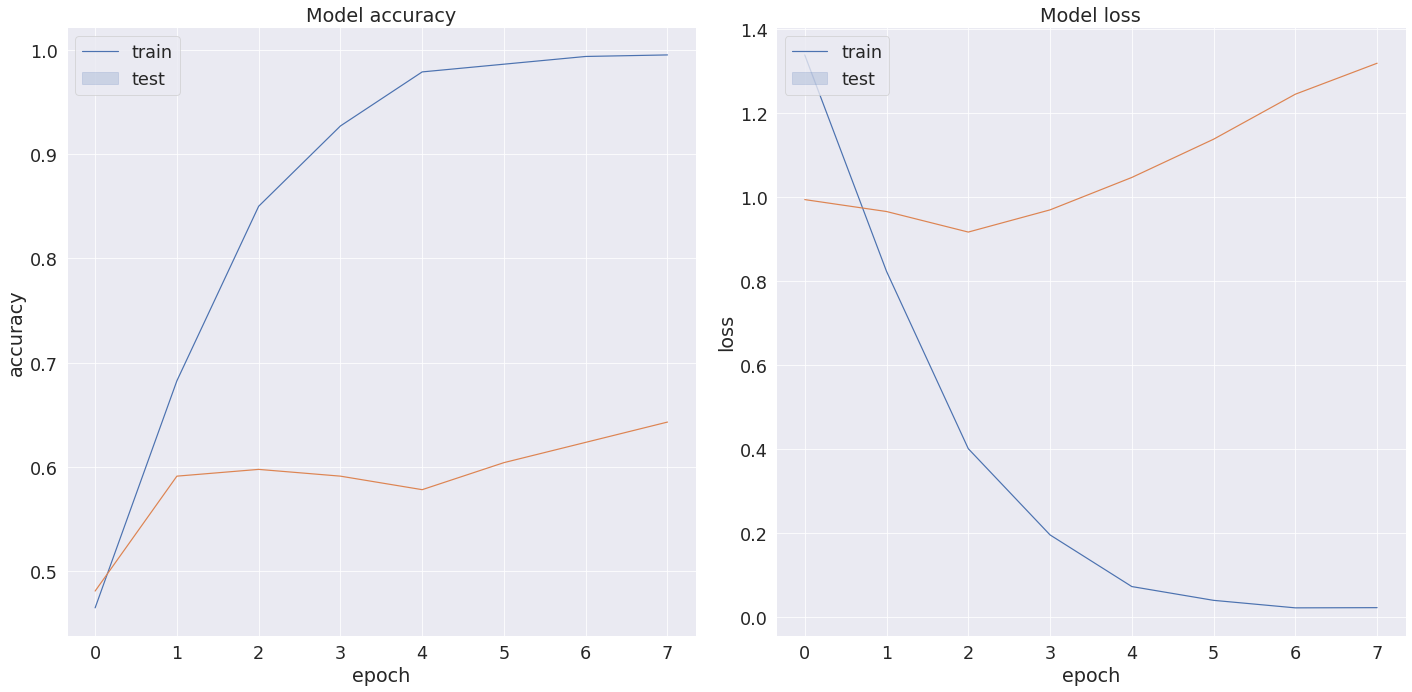

In [ ]:
sns.set()
sns.set_context("paper", font_scale=2) 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
sns.lineplot(ax=ax1, data=history.history['accuracy'])
sns.lineplot(ax=ax1, data=history.history['val_accuracy'])
ax1.set(
    title=f"Model accuracy",
    xlabel="epoch",
    ylabel="accuracy"
)
ax1.legend(['train', 'test'], loc='upper left')
ax2 = fig.add_subplot(122)
sns.lineplot(ax=ax2, data=history.history['loss'])
sns.lineplot(ax=ax2, data=history.history['val_loss'])
ax2.set(
    title=f"Model loss",
    xlabel="epoch",
    ylabel="loss"
)
ax2.legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show(fig) 

In [ ]:
y_test = tf.keras.utils.to_categorical(
    test['label'].astype('category'), num_classes=3)

In [ ]:
y_proba_cb  = classifier_model.predict(test['lemmas'].values)
y_pred = np.argmax(y_proba_cb, axis=1)
test_y = tf.keras.utils.to_categorical(
    test['label'], num_classes=3)

4/4 [==============================] - 3s 576ms/step


In [ ]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, np.argmax(y_test,axis = 1), average='macro'))
scores_F1['BERT'] = f1_score(y_pred, np.argmax(y_test,axis = 1), average='macro')
print('Accuracy:',accuracy_score(y_pred, np.argmax(y_test,axis = 1)))
scores_Accuracy['BERT'] = accuracy_score(y_pred, np.argmax(y_test,axis = 1))
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['BERT'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6126521562061632
Accuracy: 0.6346153846153846
MAE: 0.26117668


# Catboost


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train

,title,content,label,link,all_text,lemmas,feature_1489667,feature_148859,feature_1501110,feature_1240209,...,feature_838345,feature_683512,feature_236446,feature_1422712,feature_1422713,feature_849155,feature_267899,feature_788486,feature_770172,feature_189434
292,Ontario calls it quits on fighting climate cha...,Doug Ford has cancelled Ontario’s cap and trad...,0.0,canadafactcheck.ca,Ontario calls it quits on fighting climate cha...,ontario calls quits fighting climate change bu...,0.000000,0.000000,0.033663,0.057792,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.004458,0.0,0.0
212,South Africa newspaper plagiarized from Financ...,Sunday Times logo\n\nSouth Africa’s Sunday Tim...,1.0,imediaethics.org,South Africa newspaper plagiarized from Financ...,south africa newspaper plagiarized financial t...,0.000000,0.005521,0.033452,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
829,East Texas judge sets deadline for Pence in Go...,Your notification has been saved .\nThere was ...,1.0,news-journal.com,East Texas judge sets deadline for Pence in Go...,east texas judge sets deadline pence gohmert l...,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
261,Why the NDP needs a new defence critic,CAF members along with American and Polish for...,0.0,canadiandimension.com,Why the NDP needs a new defence criticCAF memb...,needs defence criticcaf members along american...,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
577,"Federal school safety panel, Parkland commissi...","The commission, led by Pinellas County Sheriff...",1.0,sayfiereview.com,"Federal school safety panel, Parkland commissi...",federal school safety panel parkland commissio...,0.000000,0.000000,0.016403,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Emails: Judicial Watch YouTube Video Censored ...,CA Secretary of State ’ s Office Pressured Goo...,2.0,judicialwatch.org,Emails: Judicial Watch YouTube Video Censored ...,emails judicial watch youtube video censored r...,0.000000,0.010422,0.036087,0.003462,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
64,Latinos Vote! Releases Ad Featuring Latina Cel...,PFAW’s Latinos Vote! released an ad on Monday ...,0.0,pfaw.org,Latinos Vote! Releases Ad Featuring Latina Cel...,latinos vote releases featuring latina celebri...,0.000000,0.002634,0.029640,0.021874,...,0.0,0.000000,0.0,0.0,0.0,0.005936,0.018576,0.000000,0.0,0.0
309,• Chart: The Largest Militaries in the World• ...,"The Statista ""Chart of the Day"", made availabl...",1.0,statista.com,• Chart: The Largest Militaries in the World• ...,chart largest militaries world chart renewable...,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
575,Interviews – Freedom NewsNews – Freedom NewsFr...,Our web store features hundreds of radical wor...,0.0,freedomnews.org.uk,Interviews – Freedom NewsNews – Freedom NewsFr...,interviews freedom newsnews freedom newsfreedo...,0.013303,0.000000,0.000000,0.010867,...,0.0,0.012969,0.0,0.0,0.0,0.000000,0.000000,0.014251,0.0,0.0


In [ ]:
np.array(train.columns)

array(['title', 'content', 'label', 'link', 'all_text', 'lemmas',
       'feature_1489667', 'feature_148859', 'feature_1501110',
       'feature_1240209', 'feature_155727', 'feature_817888',
       'feature_348737', 'feature_1351979', 'feature_866035',
       'feature_786582', 'feature_2567', 'feature_104703',
       'feature_1599668', 'feature_589954', 'feature_203832',
       'feature_1514541', 'feature_1259484', 'feature_747358',
       'feature_637290', 'feature_1514550', 'feature_823600',
       'feature_1109371', 'feature_177943', 'feature_602049',
       'feature_931941', 'feature_1362708', 'feature_1545799',
       'feature_28209', 'feature_96843', 'feature_1489743',
       'feature_246346', 'feature_167424', 'feature_810733',
       'feature_602102', 'feature_1089371', 'feature_7062',
       'feature_141877', 'feature_328889', 'feature_469205',
       'feature_595510', 'feature_595511', 'feature_704723',
       'feature_1138055', 'feature_1193853', 'feature_1576490',
       'f

## Только на фичах

In [ ]:
df_train = train[np.array(train.columns)[6:]]
y_train = train['label']
df_val = val[np.array(train.columns)[6:]]
y_val = val['label']
df_test = test[np.array(train.columns)[6:]]
y_test = test['label']

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        loss_function='MultiClass',
        class_weights=class_weights,
        iterations=6000,
        learning_rate=0.01,
        eval_metric='MultiClass',
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [ ]:
train_pool = Pool(
    df_train, y_train, 
)

validation_pool = Pool(
    df_val, y_val, 
)

test_pool = Pool(
    df_test, y_test, 
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model_f = fit_model(train_pool, validation_pool)

Train dataset shape: (674, 300)



0:	learn: 1.0955149	test: 1.0970415	best: 1.0970415 (0)	total: 49.9ms	remaining: 4m 59s
100:	learn: 0.8700205	test: 0.9628831	best: 0.9628831 (100)	total: 3.74s	remaining: 3m 38s
200:	learn: 0.7483149	test: 0.9039073	best: 0.9039073 (200)	total: 6.71s	remaining: 3m 13s
300:	learn: 0.6668466	test: 0.8713250	best: 0.8713250 (300)	total: 12s	remaining: 3m 47s
400:	learn: 0.6084887	test: 0.8474683	best: 0.8474683 (400)	total: 16.4s	remaining: 3m 48s
500:	learn: 0.5639235	test: 0.8333260	best: 0.8332348 (499)	total: 20s	remaining: 3m 39s
600:	learn: 0.5299235	test: 0.8242308	best: 0.8242308 (600)	total: 26.7s	remaining: 3m 59s
700:	learn: 0.5024167	test: 0.8170241	best: 0.8170241 (700)	total: 29.3s	remaining: 3m 41s
800:	learn: 0.4788817	test: 0.8109070	best: 0.8109070 (800)	total: 31.8s	remaining: 3m 26s
900:	learn: 0.4610164	test: 0.8067965	best: 0.8067965 (900)	total: 34.6s	remaining: 3m 15s
1000:	learn: 0.4446813	test: 0.8037569	best: 0.8037569 (1000)	total: 39s	remaining: 3m 14s
1100:	

In [ ]:
y_proba_cb = model_f.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)

In [ ]:
import tensorflow as tf
test_y = tf.keras.utils.to_categorical(
    test['label'], num_classes=3)

In [ ]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Catboost_only_features'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Catboost_only_features'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Catboost_only_features'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6684897238436259
Accuracy: 0.6730769230769231
MAE: 0.30328907093953744


## Леммы+фичи

In [ ]:
np.array(train.columns)[6:22]

array(['feature_1489667', 'feature_148859', 'feature_1501110',
       'feature_1240209', 'feature_155727', 'feature_817888',
       'feature_348737', 'feature_1351979', 'feature_866035',
       'feature_786582', 'feature_2567', 'feature_104703',
       'feature_1599668', 'feature_589954', 'feature_203832',
       'feature_1514541'], dtype=object)

In [ ]:
col = ['title', 'content','all_text', 'lemmas','feature_1489667', 'feature_148859', 'feature_1501110',
       'feature_1240209', 'feature_155727', 'feature_817888',
       'feature_348737', 'feature_1351979', 'feature_866035',
       'feature_786582', 'feature_2567', 'feature_104703',
       'feature_1599668', 'feature_589954', 'feature_203832',
       'feature_1514541']

In [ ]:
df_train = train[col]
y_train = train['label']
df_val = val[col]
y_val = val['label']
df_test = test[col]
y_test = test['label']

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        loss_function='MultiClass',
        class_weights=class_weights,
        iterations=6000,
        learning_rate=0.01,
        eval_metric='MultiClass',
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [ ]:
train_pool = Pool(
    df_train, y_train, 
    text_features=['title','all_text','lemmas','content'],
)

validation_pool = Pool(
    df_val, y_val, 
    text_features=['title','all_text','lemmas','content'],
)

test_pool = Pool(
    df_test, y_test, 
    text_features=['title','all_text','lemmas','content'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool)

Train dataset shape: (674, 20)



0:	learn: 1.0952203	test: 1.0955465	best: 1.0955465 (0)	total: 98.8ms	remaining: 9m 52s
100:	learn: 0.8560237	test: 0.8869163	best: 0.8869163 (100)	total: 3.62s	remaining: 3m 31s
200:	learn: 0.7416495	test: 0.8182240	best: 0.8182240 (200)	total: 5.01s	remaining: 2m 24s
300:	learn: 0.6623570	test: 0.7832958	best: 0.7832958 (300)	total: 6.36s	remaining: 2m
400:	learn: 0.5988313	test: 0.7652687	best: 0.7652687 (400)	total: 7.68s	remaining: 1m 47s
500:	learn: 0.5471960	test: 0.7538511	best: 0.7538511 (500)	total: 8.96s	remaining: 1m 38s
600:	learn: 0.5034886	test: 0.7441434	best: 0.7441016 (599)	total: 10.2s	remaining: 1m 31s
700:	learn: 0.4664988	test: 0.7353859	best: 0.7353859 (700)	total: 11.5s	remaining: 1m 26s
800:	learn: 0.4357321	test: 0.7278044	best: 0.7277135 (799)	total: 13s	remaining: 1m 24s
900:	learn: 0.4092522	test: 0.7225743	best: 0.7223410 (895)	total: 16.2s	remaining: 1m 31s
1000:	learn: 0.3849265	test: 0.7175424	best: 0.7174692 (997)	total: 17.3s	remaining: 1m 26s
1100:	l

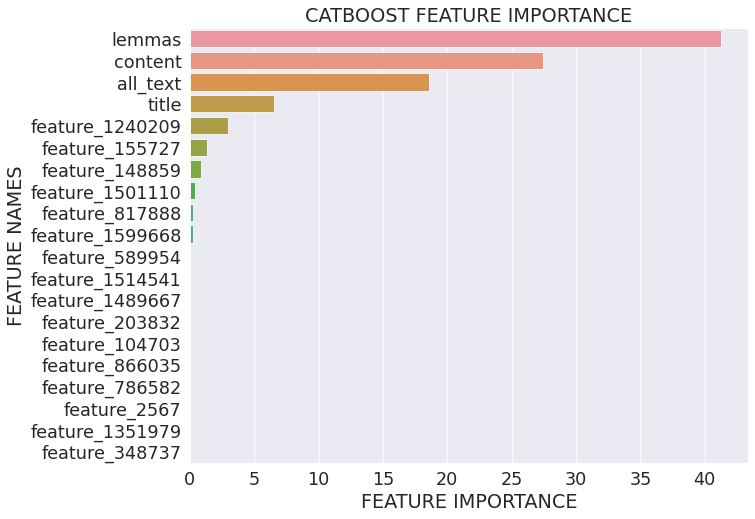

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
#plot the catboost result
plot_feature_importance(model.get_feature_importance(),df_train.columns,'CATBOOST ')

In [ ]:
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)

In [ ]:
import tensorflow as tf
test_y = tf.keras.utils.to_categorical(
    test['label'], num_classes=3)

In [ ]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Catboost'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Catboost'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Catboost'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6983908045977012
Accuracy: 0.7019230769230769
MAE: 0.2690818786492542


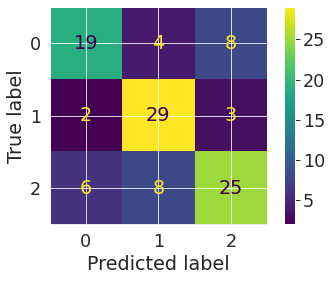

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

In [ ]:
target_names = ["0", "1", "2"]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.70      0.61      0.66        31
           1       0.71      0.85      0.77        34
           2       0.69      0.64      0.67        39

    accuracy                           0.70       104
   macro avg       0.70      0.70      0.70       104
weighted avg       0.70      0.70      0.70       104



## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf_3 = XGBClassifier(tree_method='gpu_hist',max_depth=10,n_estimators=128)

In [ ]:
y_train = train[['label']]

In [ ]:
train_vec_1 = np.array(train[np.array(train.columns)[6:]])

In [ ]:
y_train.shape

(674, 1)

In [ ]:
train_vec_1.shape

(674, 300)

In [ ]:
clf_3.fit(train_vec_1, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=128, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
test_vec_1 = np.array(test[np.array(test.columns)[6:]])

In [ ]:
y_proba_cb = clf_3.predict_proba(test_vec_1)
y_pred = np.argmax(y_proba_cb, axis=1)

In [ ]:
test_y = tf.keras.utils.to_categorical(
    test['label'], num_classes=3)

In [ ]:
print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['XGBoost'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['XGBoost'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['XGBoost'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6342310051987471
Accuracy: 0.6346153846153846
MAE: 0.2698784


#Результаты

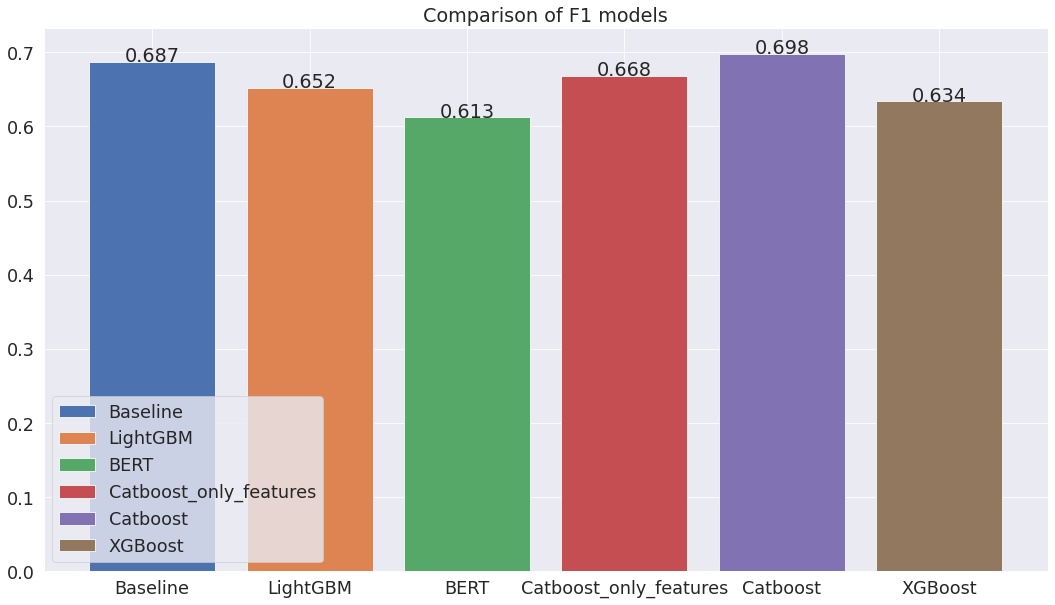

In [ ]:
fig, ax = plt.subplots(figsize =(18, 10))
for i in scores_F1.keys():
  ax.bar(i,scores_F1[i], label=i)
  plt.text(i,scores_F1[i],round(scores_F1[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of F1 models")
plt.show()

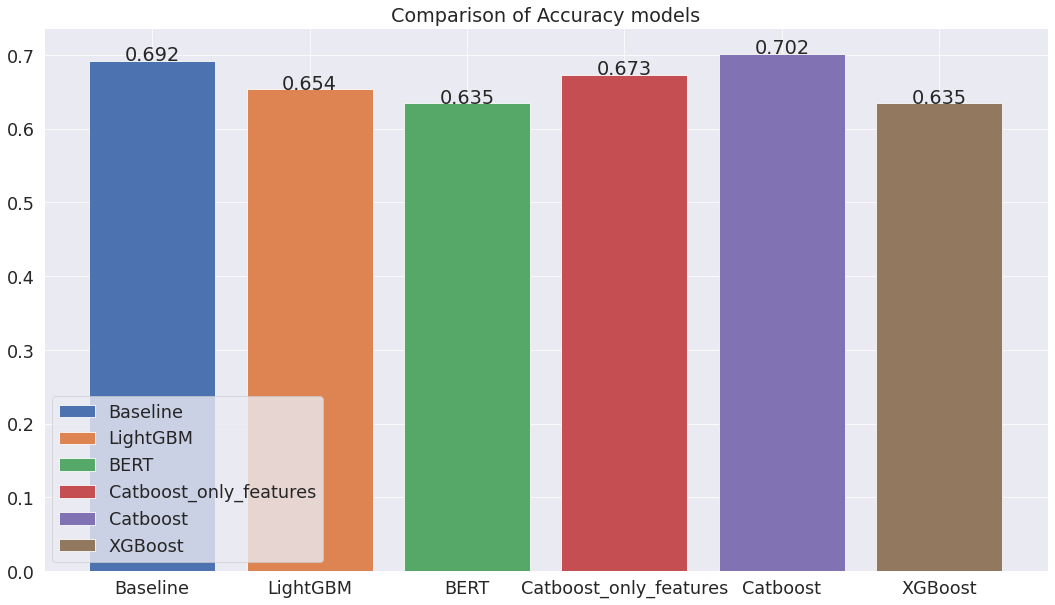

In [ ]:
fig, ax = plt.subplots(figsize =(18, 10))
for i in scores_Accuracy.keys():
  ax.bar(i,scores_Accuracy[i], label=i)
  plt.text(i,scores_Accuracy[i],round(scores_Accuracy[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of Accuracy models")
plt.show()

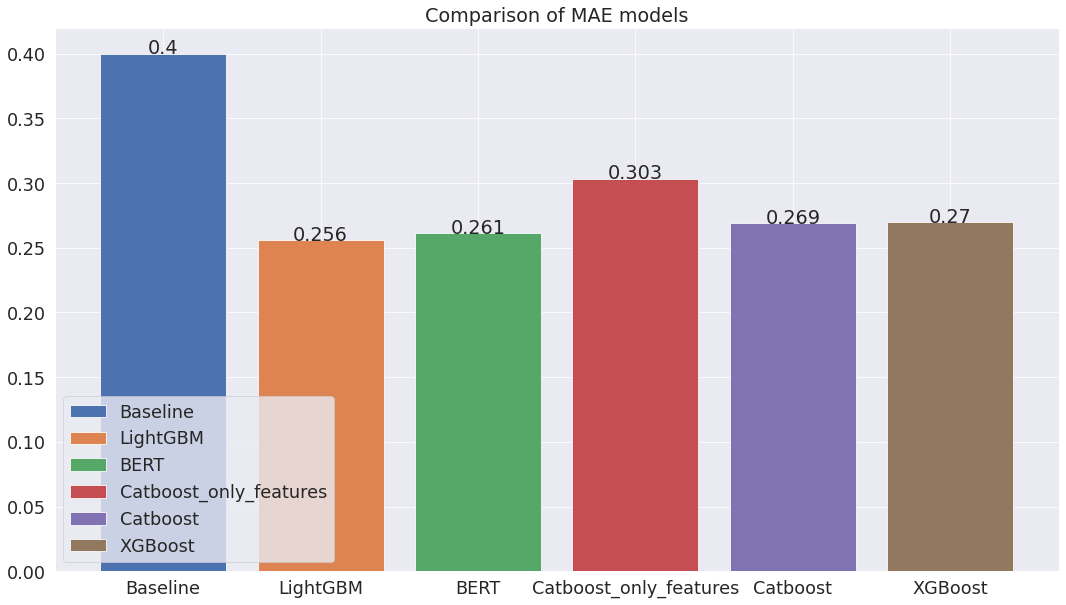

In [ ]:
fig, ax = plt.subplots(figsize =(18, 10))
for i in scores_MAE.keys():
  ax.bar(i,scores_MAE[i], label=i)
  plt.text(i,scores_MAE[i],round(scores_MAE[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of MAE models")
plt.show()